## **Keras로 ResNet-34, ResNet-50 구현하기**

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()

In [2]:
BATCH_SIZE = 32
EPOCH = 30
IMAGE_SIZE = 100

In [3]:
resize_and_rescale=tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)])

data_augmentation = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-06-26 22:02:23.221523: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-26 22:02:23.221646: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



![]()
<img src="https://imgur.com/8rUiKoZ.png" width="700px" height="300px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>  


![]()
<img src="https://imgur.com/lCp60Io.png" width="350px" height="700px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>  

In [4]:
# function for building ResNet Block

def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    is_50=False,
                    is_plane=False,
                    stride=1
                   ):
    # 입력 레이어
    x = input_layer
    
    # ResNet-50
    if is_50==True:
        # CNN 레이어
        for cnn_num in range(num_cnn):  # [3, 4, 6, 3]
            identity = x
            x = keras.layers.Conv2D(filters=channel,kernel_size=(1,1),strides=stride,padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)       
                 
            x = keras.layers.Conv2D(filters=channel,kernel_size=(3,3),strides=1,padding='same')(x)  
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)       
            
            x = keras.layers.Conv2D(filters=4*channel,kernel_size=(1,1),strides=1,padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
        
            if is_plane==False:
                identity_channel = identity.shape.as_list()[-1]
                
                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, padding='same')(identity)
                    identity = keras.layers.BatchNormalization()(identity)
                    # skip connections
                    x = keras.layers.Add()([x, identity])
            else:
                pass    
                      
            x = keras.layers.Activation('relu')(x) 

    # ResNet-34
    elif is_50==False:
        # CNN 레이어
        for cnn_num in range(num_cnn):        # [3, 4, 6, 3]
            identity = x
            
            x = keras.layers.Conv2D(filters=channel,kernel_size=(3,3),strides=2 if block_num==0 else 1,padding='same')(x)    
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)       
            x = keras.layers.Conv2D(filters=channel,kernel_size=(3,3),strides=1,padding='same')(x)  
            x = keras.layers.BatchNormalization()(x)

            # 잔차 연결
            if is_plane==False:
                # Add를 위해 shape 맞춰주기
                identity_channel = identity.shape.as_list()[-1]
                
                if identity_channel != channel:
                
                    identity = keras.layers.Conv2D(channel, kernel_size=(3,3),strides=2 if block_num==0 else 1, padding='same')(identity)
                    identity = keras.layers.BatchNormalization()(identity)
                    # skip connection
                    x = keras.layers.Add()([x, identity])
            else:
                pass
            
            x = keras.layers.Activation('relu')(x)        


    return x

In [5]:
# ResNet 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              stride=[1, 2, 2, 2],
              num_classes=10,
              is_50=False,
              is_plane=False,
              ):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = resize_and_rescale(input_layer)
    output = data_augmentation(output)
    
    output = keras.layers.Conv2D(filters=64,kernel_size=(7,7),padding='same', strides=2)(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(output)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel, s) in enumerate(zip(num_cnn_list, channel_list, stride)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            stride=s,
            is_50=False,
            is_plane=False
        )
    
    output = keras.layers.AveragePooling2D(padding='same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer,
        outputs=output
    )
    return model

In [6]:
# 기본값 : 34
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50=False, is_plane=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 100, 100, 3)  0           ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 100, 100, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 64)   9472        ['sequential_1[0][0]']           
                                                                                              

In [7]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True, is_plane=False)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 100, 100, 3)  0           ['input_2[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 100, 100, 3)  0           ['sequential[1][0]']             
                                                                                                  
 conv2d_36 (Conv2D)             (None, 50, 50, 64)   9472        ['sequential_1[1][0]']           
                                                                                            

In [8]:
# plane 모델 _34
resnet_34_plain = build_resnet(input_shape=(224, 224,3), is_50=False, is_plane=True)
resnet_34_plain.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 100, 100, 3)  0           ['input_3[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 100, 100, 3)  0           ['sequential[2][0]']             
                                                                                                  
 conv2d_72 (Conv2D)             (None, 50, 50, 64)   9472        ['sequential_1[2][0]']     

In [9]:
# plane 모델 _50
resnet_50_plain = build_resnet(input_shape=(224, 224,3), is_50=True, is_plane=True)
resnet_50_plain.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 100, 100, 3)  0           ['input_4[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 100, 100, 3)  0           ['sequential[3][0]']             
                                                                                                  
 conv2d_108 (Conv2D)            (None, 50, 50, 64)   9472        ['sequential_1[3][0]']     

## **Dataset으로 성능 비교하기**

In [10]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

DATASET = https://paperswithcode.com/dataset/cats-vs-dogs  

In [11]:
# 캐글에서 직접 다운로드
dataset=tf.keras.preprocessing.image_dataset_from_directory('/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/dogs-vs-cats/train',
                                                            shuffle=True,
                                                            image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                            batch_size=BATCH_SIZE)

class_names=dataset.class_names
class_names

Found 25000 files belonging to 2 classes.


['cat', 'dog']

In [12]:
dataset=dataset.take(int(len(dataset)/10))

In [13]:
train_data = dataset.take(int(len(dataset)*0.8))
val_data = dataset.take(int(len(dataset)*0.2))

train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resnet_34 = build_resnet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), is_50=False, is_plane=False)
resnet_50 = build_resnet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), is_50=True, is_plane=False)
resnet_34_plain = build_resnet(input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), is_50=False, is_plane=True)
resnet_50_plain = build_resnet(input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), is_50=True, is_plane=True)

In [ ]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= keras.optimizers.Adam(),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    train_data,
    epochs=EPOCH,
    validation_data=val_data,
    verbose=2,
    use_multiprocessing=True,
)

In [ ]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= keras.optimizers.Adam(),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    train_data,
    epochs=EPOCH,
    validation_data=val_data,
    verbose=2,
    use_multiprocessing=True,
)

In [ ]:
resnet_34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= keras.optimizers.Adam(),
    metrics=['accuracy'],
)

history_34_plain = resnet_34_plain.fit(
    train_data,
    epochs=EPOCH,
    validation_data=val_data,
    verbose=2,
    use_multiprocessing=True,
)

In [ ]:
resnet_50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= keras.optimizers.Adam(),
    metrics=['accuracy'],
)

history_50_plain = resnet_50_plain.fit(
    train_data,
    epochs=EPOCH,
    validation_data=val_data,
    verbose=2,
    use_multiprocessing=True,
)

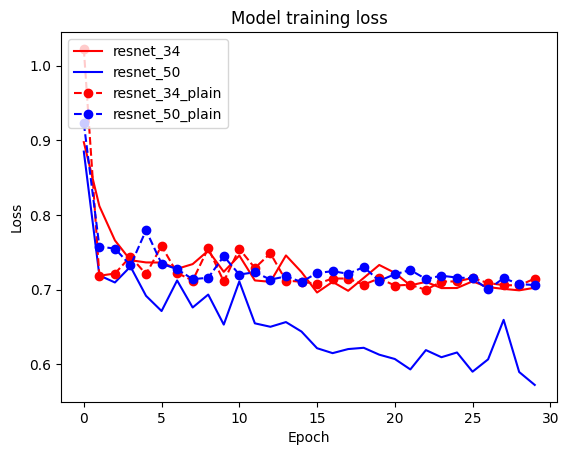

In [24]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.plot(history_34_plain.history['loss'], 'ro', linestyle='--')
plt.plot(history_50_plain.history['loss'], 'bo', linestyle='--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50','resnet_34_plain','resnet_50_plain'], loc='upper left')
plt.show()

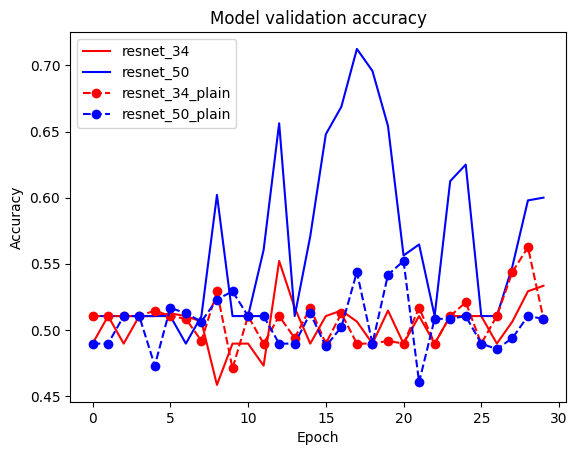

In [25]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.plot(history_34_plain.history['val_accuracy'], 'ro', linestyle='--')
plt.plot(history_50_plain.history['val_accuracy'], 'bo', linestyle='--')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50','resnet_34_plain','resnet_50_plain'], loc='upper left')
plt.show()

#### **[LOSS 비교]**

|                    | 5      | 10     | 15     | 20     | 25     | 30           |
|:------------------:|:------:|:------:|:------:|:------:|:------:|:------------:|
|**ResNet-34**       | 0.7365 | 0.7239 | 0.7236 | 0.7331 | 0.7023 | 0.7026       |
|**ResNet-50**       | 0.6918 | 0.6532 | 0.6439 | 0.6130 | 0.6159 | **`0.5725`** |
|**(plain)ResNet-34**| 0.7208 | 0.7110 | 0.7106 | 0.7152 | 0.7111 | 0.7148       |
|**(plain)ResNet-50**| 0.7795 | 0.7448 | 0.7104 | 0.7119 | 0.7162 | 0.7062       |

#### **[ACCURACY 비교]**

|                    | 5      | 10     | 15     | 20     | 25     | 30           |
|:------------------:|:------:|:------:|:------:|:------:|:------:|:------------:|
|**ResNet-34**       | 0.4904 | 0.4889 | 0.5015 | 0.5081 | 0.4934 | 0.5091       |
|**ResNet-50**       | 0.5827 | 0.6321 | 0.6406 | 0.6678 | 0.6593 | **`0.7061`** |
|**(plain)ResNet-34**| 0.4940 | 0.5146 | 0.4934 | 0.5101 | 0.4924 | 0.4869       |
|**(plain)ResNet-50**| 0.4985 | 0.4859 | 0.5040 | 0.5040 | 0.4924 | 0.5101       |

#### **ResNet-50의 loss와 accuracy가 확연히 좋음을 확인할 수 있음**

---

**참고문헌**  
- He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.  
- He, Kaiming, et al. "Identity mappings in deep residual networks." Computer Vision–ECCV 2016: 14th European Conference, Amsterdam, The Netherlands, October 11–14, 2016, Proceedings, Part IV 14. Springer International Publishing, 2016.  